In [3]:
'''
Load imports
'''
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import geopandas as gpd
import math
import geopy.distance
import seaborn as sns
from tqdm import tqdm
from itertools import combinations
from datetime import datetime

import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import variance_inflation_factor

from stargazer.stargazer.stargazer import Stargazer

import warnings
warnings.filterwarnings('ignore')

# Probability Regressions

In [81]:
'''
Add regression variables: 
    Characteristics of individual's block group: median income, racial comp
    Characteristics of closest POI: 
    Characteristics of chosen POI: 
'''
def add_demographic_vars(reg_df, ma_geodata):
    ma_geodata_mod = ma_geodata.drop(['TRACTCE','BLKGRPCE', 'NAMELSAD', 'MTFCC', 'FUNCSTAT', 'ALAND', 'AWATER', 'STATEFP', 'COUNTYFP'], axis=1)
    reg_df = reg_df.merge(ma_geodata_mod, left_on='GEOID_home', right_on='GEOID')
    reg_df['black_ratio'] = reg_df['black']/reg_df['population']

    # normalize_col(reg_df, 'travel_time')
    normalize_col(reg_df, 'black_ratio')
    normalize_col(reg_df, 'median_income')
    normalize_col(reg_df, 'ratio_poverty')

    # filter out cbgs with less than 400 population
    reg_df = reg_df[reg_df['population']>400]

    return reg_df

def add_education_vars(reg_df, edu_data, rcol_name = 'GEOID'):
    usecols=['B15003_022','B15003_023', 'B15003_024', 'B15003_025', 'B15003_001']
    edu_data = edu_data[edu_data['variable'].isin(usecols)]
    
    edu_prop = []
    for i, r in tqdm(reg_df.iterrows()):
        match = edu_data[edu_data['GEOID']==r[rcol_name]]
        if not match.empty:
            total_pop = match[match['variable']=="B15003_001"].reset_index()['estimate'].iloc[0]
            bachelors = match[match['variable']=="B15003_022"].reset_index()['estimate'].iloc[0]
            masters = match[match['variable']=="B15003_023"].reset_index()['estimate'].iloc[0]
            prof_school = match[match['variable']=="B15003_024"].reset_index()['estimate'].iloc[0]
            doctorate = match[match['variable']=="B15003_025"].reset_index()['estimate'].iloc[0]
            edu_prop.append(sum([bachelors,masters,prof_school,doctorate])/total_pop)
        else:
            edu_prop.append(None)
    reg_df['edu'] = edu_prop
    normalize_col(reg_df, 'edu')
    return reg_df

def add_race_vars(reg_df, race_data, rcol_name = 'GEOID'):
    usecols=['B03002_001','B03002_003', 'B03002_004', 'B03002_006', 'B03002_012']
    race_data = race_data[race_data['variable'].isin(usecols)]
    
    white_prop = []
    black_prop = []
    race_dict = {} #GEOID: (white_prop, black_prop)

    for i,r in tqdm(reg_df.iterrows()):
        if r[rcol_name] in race_dict:
            white_prop.append(race_dict[r[rcol_name]][0])
            black_prop.append(race_dict[r[rcol_name]][1])
        else:
            match = race_data[race_data['GEOID']==r[rcol_name]]
            if not match.empty:
                total_pop = match[match['variable']=="B03002_001"].reset_index()['estimate'].iloc[0]
                white = match[match['variable']=="B03002_003"].reset_index()['estimate'].iloc[0]/total_pop
                white_prop.append(white)
                black = match[match['variable']=="B03002_004"].reset_index()['estimate'].iloc[0]/total_pop
                black_prop.append(black)
                race_dict[r[rcol_name]] = (white, black)
            else:
                white_prop.append(None)
                black_prop.append(None)
                race_dict[r[rcol_name]] = (None, None)
    
    reg_df['wht'] = white_prop
    reg_df['blk'] = black_prop
    
    normalize_col(reg_df, 'wht')
    normalize_col(reg_df, 'blk')
    
    return reg_df

def add_commute_time_vars(reg_df, commute_data, rcol_name = 'GEOID'): 
    commute_quantile = []
    for i, r in tqdm(reg_df.iterrows()):
        match = commute_data[commute_data['GEOID']==r[rcol_name]]
        if not match.empty:
            total_pop = match[match['variable']=="B08303_001"].reset_index()['estimate'].iloc[0]
            lt5 = match[match['variable']=="B08303_002"].reset_index()['estimate'].iloc[0]
            five_to9 = match[match['variable']=="B08303_003"].reset_index()['estimate'].iloc[0]
            ten_to14 = match[match['variable']=="B08303_004"].reset_index()['estimate'].iloc[0]
            fifteen_to19 = match[match['variable']=="B08303_005"].reset_index()['estimate'].iloc[0]
            commute_quantile.append(sum([lt5, five_to9, ten_to14, fifteen_to19])/total_pop)
        else:
            commute_quantile.append(None)
    reg_df['commute_lt20'] = commute_quantile # proportion of population with commute time less than 20 min
    normalize_col(reg_df, 'commute_lt20')
    return reg_df

def normalize_col(df, col_name):
    new_name = col_name+"_normalized"
    df[new_name] = (df[col_name] - df[col_name].mean())/df[col_name].std()

In [84]:
edu_data = pd.read_csv("generated_data/census_data/eduMA.csv")
race_data = pd.read_csv("generated_data/census_data/raceMA.csv")
commute_data = pd.read_csv("generated_data/census_data/commute_time.csv")

In [83]:
ma_geodata = gpd.read_file("misc/2017_ma_tiger/14460_MSA_blocks.geojson")
ma_geodata['GEOID'] = ma_geodata['GEOID'].astype(int)
ma_geodata['INTPTLON'] = ma_geodata['INTPTLON'].astype(float)
ma_geodata['INTPTLAT'] = ma_geodata['INTPTLAT'].astype(float)
ma_geodata['square_miles'] = ma_geodata['ALAND'].astype(int)/(2.59*(10**6))
ma_geodata['ppsm'] = ma_geodata['population']/ma_geodata['square_miles']

# using relabled grocery / supermarket data

In [89]:
groceries = pd.read_csv("generated_data/boston_groceries.csv")
valid_groceries = groceries[groceries['full_service']=='Yes']
valid_groceries_fsq_list = list(valid_groceries['id'])
# valid_gssm_stays = full_stays[full_stays['fsq_id'].isin(valid_groceries_fsq_list)]

# valid_gssm_stays.to_csv("nonvalid_gssm_stays.csv", index=False)
# go to R

In [90]:
valid_gssm_stays = pd.read_csv("generated_data/valid_gssm_stays.csv")

In [85]:
all_vars = add_education_vars(ma_geodata[['GEOID', 'ratio_poverty','population','ALAND','ppsm']], edu_data, rcol_name='GEOID')
all_vars = add_race_vars(all_vars, race_data, rcol_name='GEOID')
all_vars = add_commute_time_vars(all_vars, commute_data, rcol_name='GEOID')

3418it [00:27, 125.66it/s]
3418it [00:17, 193.44it/s]
3418it [00:27, 123.52it/s]


In [131]:
valid_gssm_stays = valid_gssm_stays.merge(all_vars, left_on='GEOID_home', right_on='GEOID', how='left')
valid_gssm_stays['pop_density'] = valid_gssm_stays['population'] / pd.to_numeric(valid_gssm_stays['ALAND'])
normalize_col(valid_gssm_stays, 'pop_density')
valid_gssm_stays['poverty_quant'] = pd.qcut(valid_gssm_stays['ratio_poverty'], 4, labels=False)

valid_gssm_stays['diff'] = valid_gssm_stays['disthome'] - valid_gssm_stays['distclosest']

# within half a kilometer
# valid_gssm_stays['logit'] = np.where(valid_gssm_stays['diff']<1, 1, 0) 

# choice EC Distance with 5 km = 15 min driving
# valid_gssm_stays['logit'] = np.where(valid_gssm_stays['disthome']<5, 1, 0)

valid_gssm_stays['radius'] = np.maximum(1.2*valid_gssm_stays['distclosest'], 1)
valid_gssm_stays['logit'] = np.where(valid_gssm_stays['disthome'] < valid_gssm_stays['radius'], 1, 0)

# toggle urban v rural
# valid_gssm_stays = valid_gssm_stays[valid_gssm_stays['ppsm']>=1000]

In [109]:
# results1 = smf.logit('logit ~ wht_normalized + blk_normalized', data = valid_gssm_stays).fit()
# results2 = smf.logit('logit ~ wht_normalized + blk_normalized + poverty_quant', data = valid_gssm_stays).fit()
# results3 = smf.logit('logit ~ wht_normalized + blk_normalized + poverty_quant + wht_normalized:quant', data = valid_gssm_stays).fit()
# results4 = smf.logit('logit ~ wht_normalized + blk_normalized + poverty_quant + wht_normalized:quant + pop_density_normalized', data = valid_gssm_stays).fit()
# results5 = smf.logit('logit ~ wht_normalized + blk_normalized + poverty_quant + wht_normalized:quant + pop_density_normalized + edu_normalized', data = valid_gssm_stays).fit()
# results6 = smf.logit('logit ~ wht_normalized + blk_normalized + poverty_quant + wht_normalized:quant + pop_density_normalized + edu_normalized + commute_lt20_normalized', data = valid_gssm_stays).fit()

results1 = smf.logit('logit ~ wht_normalized + blk_normalized', data = valid_gssm_stays).fit()
results2 = smf.logit('logit ~ wht_normalized + blk_normalized + poverty_quant', data = valid_gssm_stays).fit()
results3 = smf.logit('logit ~ wht_normalized + blk_normalized + poverty_quant + wht_normalized:quant', data = valid_gssm_stays).fit()
results4 = smf.logit('logit ~ wht_normalized + blk_normalized + poverty_quant + wht_normalized:quant + edu_normalized', data = valid_gssm_stays).fit()
results5 = smf.logit('logit ~ wht_normalized + blk_normalized + poverty_quant + wht_normalized:quant + edu_normalized + commute_lt20_normalized', data = valid_gssm_stays).fit()


stargazer = Stargazer([results1,results2,results3, results4, results5])
stargazer.covariate_order(["wht_normalized", "blk_normalized",
                          "poverty_quant", "wht_normalized:quant", 
                           #"pop_density_normalized",
                           "edu_normalized", "commute_lt20_normalized"])
stargazer.dependent_variable_name("Log odds of choosing nearest POI")
print(stargazer.render_html())

# vif(valid_gssm_stays, ["wht_normalized", "blk_normalized",
#                         "poverty_quant", #"pop_density_normalized",
#                     "edu_normalized", "commute_lt20_normalized"])


Optimization terminated successfully.
         Current function value: 0.638841
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.637097
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.636982
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.634618
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.632277
         Iterations 5
<table style="text-align:center"><tr><td colspan="6" style="border-bottom: 1px solid black"></td></tr><tr><td style="text-align:left"></td><td colspan="5"><em>Log odds of choosing nearest POIlogit</em></td></tr><tr><td style="text-align:left"></td><tr><td style="text-align:left"></td><td>(1)</td><td>(2)</td><td>(3)</td><td>(4)</td><td>(5)</td></tr><tr><td colspan="6" style="border-bottom: 1px solid black"></td></tr>

<tr><td style="text-align:left">wht_normalized</td><td>0.542<sup>***<

In [117]:
valid_gssm_stays['weekday'] = valid_gssm_stays['ini_dat'].apply(lambda x: datetime.fromtimestamp(x).weekday())
weekend_stays = valid_gssm_stays[valid_gssm_stays['weekday']<5]

# results1 = smf.logit('logit ~ wht_normalized + blk_normalized', data = weekend_stays).fit()
# results2 = smf.logit('logit ~ wht_normalized + blk_normalized + poverty_quant', data = weekend_stays).fit()
# results3 = smf.logit('logit ~ wht_normalized + blk_normalized + poverty_quant + wht_normalized:quant', data = weekend_stays).fit()
# results4 = smf.logit('logit ~ wht_normalized + blk_normalized + poverty_quant + wht_normalized:quant + pop_density_normalized', data = weekend_stays).fit()
# results5 = smf.logit('logit ~ wht_normalized + blk_normalized + poverty_quant + wht_normalized:quant + pop_density_normalized + edu_normalized', data = weekend_stays).fit()
# results6 = smf.logit('logit ~ wht_normalized + blk_normalized + poverty_quant + wht_normalized:quant + pop_density_normalized + edu_normalized + commute_lt20_normalized', data = weekend_stays).fit()

results1 = smf.logit('logit ~ wht_normalized + blk_normalized', data = weekend_stays).fit()
results2 = smf.logit('logit ~ wht_normalized + blk_normalized + poverty_quant', data = weekend_stays).fit()
results3 = smf.logit('logit ~ wht_normalized + blk_normalized + poverty_quant + wht_normalized:quant', data = weekend_stays).fit()
results4 = smf.logit('logit ~ wht_normalized + blk_normalized + poverty_quant + wht_normalized:quant + edu_normalized', data = weekend_stays).fit()
results5 = smf.logit('logit ~ wht_normalized + blk_normalized + poverty_quant + wht_normalized:quant + edu_normalized + commute_lt20_normalized', data = weekend_stays).fit()


stargazer = Stargazer([results1,results2,results3, results4, results5])
stargazer.covariate_order(["wht_normalized", "blk_normalized",
                          "poverty_quant", "wht_normalized:quant", 
                           # "pop_density_normalized",
                           "edu_normalized", "commute_lt20_normalized"])
stargazer.dependent_variable_name("Log odds of choosing nearest POI")
print(stargazer.render_html())

# vif(weekend_stays, ["wht_normalized", "blk_normalized",
#                         "poverty_quant", "pop_density_normalized",
#                     "edu_normalized", "commute_lt20_normalized"])


0.2663366593684283
Optimization terminated successfully.
         Current function value: 0.576302
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.575952
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.575826
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.575823
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.575541
         Iterations 5
<table style="text-align:center"><tr><td colspan="6" style="border-bottom: 1px solid black"></td></tr><tr><td style="text-align:left"></td><td colspan="5"><em>Log odds of choosing nearest POIlogit</em></td></tr><tr><td style="text-align:left"></td><tr><td style="text-align:left"></td><td>(1)</td><td>(2)</td><td>(3)</td><td>(4)</td><td>(5)</td></tr><tr><td colspan="6" style="border-bottom: 1px solid black"></td></tr>

<tr><td style="text-align:left">wht_normalized</td

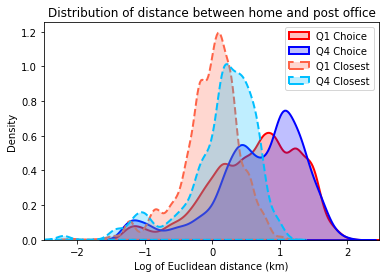

In [173]:
log_dist_q1 = np.log10(po_stays[po_stays['quant']==1]['disthome'])
log_dist_q4 = np.log10(po_stays[po_stays['quant']==4]['disthome'])
log_dist_q1c = np.log10(po_stays[po_stays['quant']==1]['distclosest'])
log_dist_q4c = np.log10(po_stays[po_stays['quant']==4]['distclosest'])

# log_dist_q1 = np.log10(valid_gssm_stays[valid_gssm_stays['quant']==1]['disthome'])
# log_dist_q4 = np.log10(valid_gssm_stays[valid_gssm_stays['quant']==4]['disthome'])
# log_dist_q1c = np.log10(valid_gssm_stays[valid_gssm_stays['quant']==1]['distclosest'])
# log_dist_q4c = np.log10(valid_gssm_stays[valid_gssm_stays['quant']==4]['distclosest'])
sns.distplot(log_dist_q1, hist=False, kde=True, color='red', kde_kws={'linewidth':2, 'shade':True}, label='Q1 Choice')
sns.distplot(log_dist_q4, hist=False, kde=True, color='blue', kde_kws={'linewidth':2, 'shade':True}, label='Q4 Choice')
sns.distplot(log_dist_q1c, hist=False, kde=True, color='tomato', kde_kws={'linewidth':2, 'shade':True, 'linestyle':'--'}, label='Q1 Closest')
sns.distplot(log_dist_q4c, hist=False, kde=True, color='deepskyblue', kde_kws={'linewidth':2, 'shade':True, 'linestyle':'--'}, label='Q4 Closest')

plt.title('Distribution of distance between home and post office')
plt.xlabel('Log of Euclidean distance (km)')
plt.ylabel('Density')
plt.margins(x=0)
plt.legend(labels=['Q1 Choice','Q4 Choice', 'Q1 Closest', 'Q4 Closest'])
plt.show()

In [1670]:
np.exp(results6.params)

Intercept                  0.372779
wht_normalized             1.010121
blk_normalized             0.895741
poverty_quant              1.027537
wht_normalized:quant       1.052263
pop_density_normalized     1.019380
edu_normalized             0.932955
commute_lt20_normalized    1.103092
dtype: float64

# post offices

In [1259]:
po_stays = full_stays[full_stays['cat']=='Post Office']
po_stays.to_csv("generated_data/po_stays.csv", index=False)
# run R

In [133]:
po_stays = pd.read_csv("generated_data/po_stays.csv")

In [134]:
po_stays = po_stays.merge(all_vars, left_on='GEOID_home', right_on='GEOID', how='left')
normalize_col(po_stays, 'ratio_poverty')
po_stays['pop_density'] = po_stays['population'] / pd.to_numeric(po_stays['ALAND'])
normalize_col(po_stays, 'pop_density')
po_stays['poverty_quant'] = pd.qcut(po_stays['ratio_poverty'], 4, labels=False)

po_stays['diff'] = po_stays['disthome'] - po_stays['distclosest']

# po_stays['logit'] = np.where(po_stays['diff']<1, 1, 0) #within one kilometer
# po_stays['logit'] = np.where(po_stays['disthome']< 5, 1, 0) #within 5 kilometer

# po_stays['logit'] = np.where(po_stays['disthome'] < 1.1*po_stays['distclosest'], 1, 0)

po_stays['radius'] = np.maximum(1.2*po_stays['distclosest'], 1)
po_stays['logit'] = np.where(po_stays['disthome'] < po_stays['radius'], 1, 0)

# po_stays = po_stays[po_stays['ppsm']>=1000]


In [ ]:
results1 = smf.logit('logit ~ wht_normalized + blk_normalized', data = po_stays).fit()
results2 = smf.logit('logit ~ wht_normalized + blk_normalized + poverty_quant', data = po_stays).fit()
results3 = smf.logit('logit ~ wht_normalized + blk_normalized + poverty_quant + wht_normalized:quant', data = po_stays).fit()
results4 = smf.logit('logit ~ wht_normalized + blk_normalized + poverty_quant + wht_normalized:quant + pop_density_normalized', data = po_stays).fit()
results5 = smf.logit('logit ~ wht_normalized + blk_normalized + poverty_quant + wht_normalized:quant + pop_density_normalized + edu_normalized', data = po_stays).fit()
results6 = smf.logit('logit ~ wht_normalized + blk_normalized + poverty_quant + wht_normalized:quant + pop_density_normalized + edu_normalized + commute_lt20_normalized', data = po_stays).fit()

stargazer = Stargazer([results1,results2,results3, results4, results5, results6])
stargazer.covariate_order(["wht_normalized", "blk_normalized",
                          "poverty_quant", "wht_normalized:quant", 
                           "pop_density_normalized",
                           "edu_normalized", "commute_lt20_normalized"])
stargazer.dependent_variable_name("Log odds of choosing nearest POI")
print(stargazer.render_html())

vif(po_stays, ["wht_normalized", "blk_normalized",
                        "poverty_quant", "pop_density_normalized",
                    "edu_normalized", "commute_lt20_normalized"])


In [129]:
# weekdays v weekends
po_stays['weekday'] = po_stays['ini_dat'].apply(lambda x: datetime.fromtimestamp(x).weekday())
weekdays_po_stays = po_stays[po_stays['weekday']>=5]
print(weekdays_po_stays['logit'].mean())

# results1 = smf.logit('logit ~ wht_normalized + blk_normalized', data = weekdays_po_stays).fit()
# results2 = smf.logit('logit ~ wht_normalized + blk_normalized + poverty_quant', data = weekdays_po_stays).fit()
# results3 = smf.logit('logit ~ wht_normalized + blk_normalized + poverty_quant + wht_normalized:quant', data = weekdays_po_stays).fit()
# results4 = smf.logit('logit ~ wht_normalized + blk_normalized + poverty_quant + wht_normalized:quant + pop_density_normalized', data = weekdays_po_stays).fit()
# results5 = smf.logit('logit ~ wht_normalized + blk_normalized + poverty_quant + wht_normalized:quant + pop_density_normalized + edu_normalized', data = weekdays_po_stays).fit()
# results6 = smf.logit('logit ~ wht_normalized + blk_normalized + poverty_quant + wht_normalized:quant + pop_density_normalized + edu_normalized + commute_lt20_normalized', data = weekdays_po_stays).fit()

results1 = smf.logit('logit ~ wht_normalized + blk_normalized', data = weekdays_po_stays).fit()
results2 = smf.logit('logit ~ wht_normalized + blk_normalized + poverty_quant', data = weekdays_po_stays).fit()
results3 = smf.logit('logit ~ wht_normalized + blk_normalized + poverty_quant + wht_normalized:quant', data = weekdays_po_stays).fit()
results4 = smf.logit('logit ~ wht_normalized + blk_normalized + poverty_quant + wht_normalized:quant + edu_normalized', data = weekdays_po_stays).fit()
results5 = smf.logit('logit ~ wht_normalized + blk_normalized + poverty_quant + wht_normalized:quant + edu_normalized + commute_lt20_normalized', data = weekdays_po_stays).fit()

stargazer = Stargazer([results1,results2,results3, results4, results5])
stargazer.covariate_order(["wht_normalized", "blk_normalized",
                          "poverty_quant", "wht_normalized:quant", 
                           # "pop_density_normalized",
                           "edu_normalized", "commute_lt20_normalized"])
stargazer.dependent_variable_name("Log odds of choosing nearest POI")
print(stargazer.render_html())

# vif(weekdays_po_stays, ["wht_normalized", "blk_normalized",
#                         "poverty_quant", "pop_density_normalized",
#                     "edu_normalized", "commute_lt20_normalized"])


0.3625254582484725
Optimization terminated successfully.
         Current function value: 0.642721
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.642239
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.642004
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.639936
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.637061
         Iterations 5
<table style="text-align:center"><tr><td colspan="6" style="border-bottom: 1px solid black"></td></tr><tr><td style="text-align:left"></td><td colspan="5"><em>Log odds of choosing nearest POIlogit</em></td></tr><tr><td style="text-align:left"></td><tr><td style="text-align:left"></td><td>(1)</td><td>(2)</td><td>(3)</td><td>(4)</td><td>(5)</td></tr><tr><td colspan="6" style="border-bottom: 1px solid black"></td></tr>

<tr><td style="text-align:left">wht_normalized</td

# create bar plot 

In [24]:
labels = ['White', 'Black', 'Poverty Quant', "White * Quant", 'Education', 'Commute']
urban_coeffs = [-0.008, -0.120, 0.002, 0.056, -0.079, 0.059]
urban_error = [0.026, 0.015, 0.010, 0.012, 0.012, 0.010]
rural_coeffs = [-0.174, -0.665, 0.027, 0.141, -0.421, 0.147]
rural_error = [0.110, 0.097, 0.019, 0.028, 0.029, 0.024]

# urban_coeffs = [-0.088, -0.170, 0.068, 0.051, 0.021, 0.060]
# urban_error = [0.019, 0.011, 0.008, 0.009, 0.009, 0.008]
# rural_coeffs = [0.133, -0.550, 0.107, 0.076, -0.146, 0.227]
# rural_error = [0.082, 0.078, 0.014, 0.021, 0.021, 0.018]

# urban_coeffs = [0.540, 0.288, 0.094, -0.063, 0.193, 0.170]
# urban_error = [0.108, 0.062, 0.036, 0.044, 0.043, 0.037]
# rural_coeffs = [-0.486, -0.872, -0.262, 0.266, 0.280, 0.374]
# rural_error = [0.377, 0.306, 0.065, 0.099, 0.096, 0.090]

# urban_coeffs = [0.139, 0.131, 0.050, -0.017, 0.270, 0.245]
# urban_error = [0.051, 0.029, 0.018, 0.023, 0.022, 0.019]
# rural_coeffs = [-0.344, -1.075, -0.157, 0.190, 0.513, 0.198]
# rural_error = [0.224, 0.185, 0.037, 0.060, 0.059, 0.053]

cat = ['Urban', 'Rural']


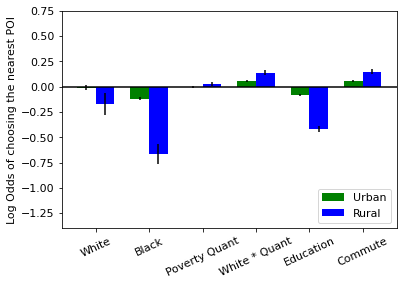

In [25]:
x = np.arange(len(labels))  # the label locations
width = 0.35        # the width of the bars

plt.rcParams.update({'font.size': 11})

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, urban_coeffs, width, label='Urban', yerr = urban_error, color='green')
rects2 = ax.bar(x + width/2, rural_coeffs, width, label='Rural', yerr=rural_error, color='blue')

ax.set_ylabel('Log Odds of choosing the nearest POI')
ax.legend(loc="lower right")

plt.ylim([-1.4, 0.75])  
plt.xticks(x, labels)
plt.xticks(rotation=25)
plt.axhline(0, color='black')
plt.show()

In [36]:
plt.rcParams.update(plt.rcParamsDefault)

In [38]:
# weekdays
labels = ['White', 'Black', 'Poverty Quant', "White * Quant", 'Population Density', 'Education', 'Commute']
gssm_coeffs = [-0.030,-0.159,0.077,0.086,0.041,-0.035,0.081]
gssm_error = [0.018,0.011,0.007,0.008,0.007,0.008,0.007]
po_coeffs = [-0.018,0.108,-0.022,0.067,0.052,0.291,0.220]
po_error = [0.049,0.029,0.017,0.020,0.017,0.021,0.018]
cat = ['Grocery Stores', 'Post Offices']


In [41]:
# weekends
labels = ['White', 'Black', 'Poverty Quant', "White * Quant", 'Population Density', 'Education', 'Commute']
gssm_coeffs = [0.047,-0.117,0.003,0.091,0.039,-0.157,0.064]
gssm_error = [0.025,0.015,0.009,0.011,0.010,0.010,0.009]
po_coeffs = [0.346,0.234,-0.013,0.016,0.099,0.193,0.177]
po_error = [0.104,0.059,0.031,0.038,0.035,0.038,0.034]
cat = ['Grocery Stores', 'Post Offices']


In [53]:
# weekdays - 5km
labels = ['White', 'Black', 'Poverty Quant', "White * Quant", 'Population Density', 'Education', 'Commute']
gssm_coeffs = [-0.011,0.016,0.062,-0.075,0.265,0.102,0.150]
gssm_error = [0.017,0.009,0.006,0.007,0.008,0.007,0.007]
po_coeffs = [-0.020,0.031,0.107,0.002,0.450,0.308,0.316]
po_error = [0.045,0.025,0.016,0.019,0.021,0.020,0.017]
cat = ['Grocery Stores', 'Post Offices']


In [60]:
# weekends - 5km
labels = ['White', 'Black', 'Poverty Quant', "White * Quant", 'Population Density', 'Education', 'Commute']
gssm_coeffs = [-0.031,0.007,-0.001,-0.018,0.315,-0.028,0.181]
gssm_error = [0.024,0.014,0.008,0.010,0.011,0.010,0.009]
po_coeffs = [0.312,0.226,0.074,-0.076,0.370,0.251,0.177]
po_error = [0.097,0.054,0.030,0.037,0.041,0.037,0.033]
cat = ['Grocery Stores', 'Post Offices']


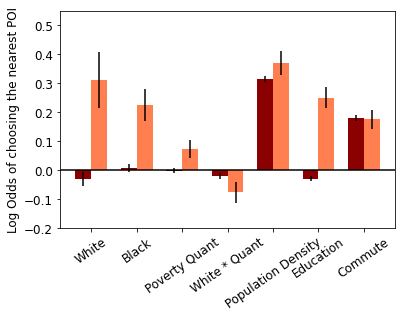

In [62]:
x = np.arange(len(labels))  # the label locations
width = 0.35        # the width of the bars

plt.rcParams.update({'font.size': 12})

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, gssm_coeffs, width, label='Grocery Stores', yerr = gssm_error, color='darkred')
rects2 = ax.bar(x + width/2, po_coeffs, width, label='Post Offices', yerr= po_error, color='coral')

ax.set_ylabel('Log Odds of choosing the nearest POI')
# ax.legend(loc="upper left")

plt.ylim([-0.2, 0.55])  
plt.xticks(x, labels)
plt.xticks(rotation=35)
plt.axhline(0, color='black')
plt.show()

# corr heatmaps

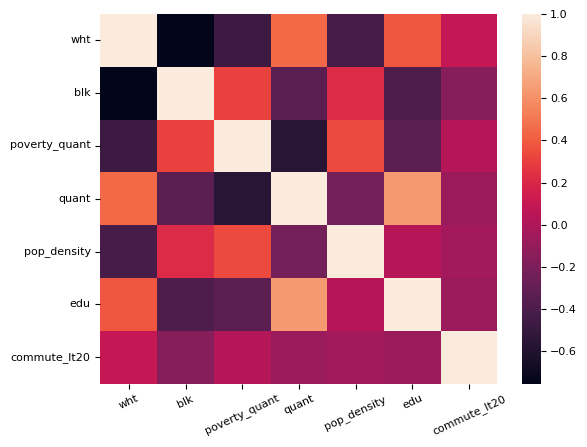

In [1611]:
dataplot=sns.heatmap(data.corr())
plt.xticks(rotation=25)
plt.show()

In [1610]:
data = po_stays[['wht', 'blk', 'poverty_quant','pop_density','edu','commute_lt20']]

In [1754]:
valid_gssm_stays['logit'].mean()

0.37871939892523054

In [1618]:
po_stays['logit'].mean()

0.5125843279709393

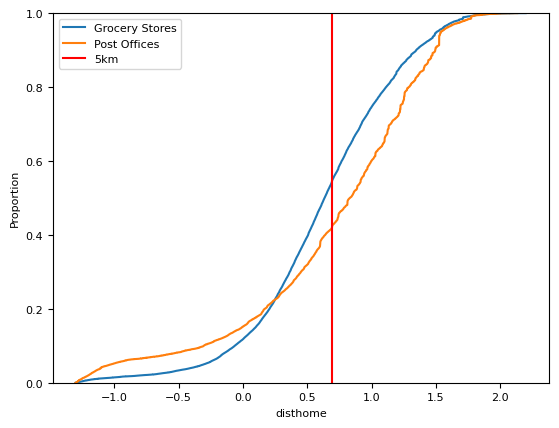

In [1829]:
sns.ecdfplot(np.log10(valid_gssm_stays['disthome']))
sns.ecdfplot(np.log10(po_stays['disthome']))
plt.axvline(0.69, color='red')
plt.legend(labels=['Grocery Stores', 'Post Offices', '5km'])
plt.show()

# line plot of tolerance

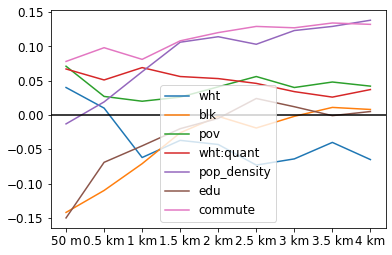

In [63]:
'''
difference between closest and choice
'''
x_vals = ['50 m', '0.5 km', '1 km', '1.5 km', '2 km', '2.5 km', '3 km', '3.5 km', '4 km']

# 50m, 0.5km, 1km
wht = [0.04, 0.01, -0.062, -0.037, -0.043, -0.073, -0.064, -0.04, -0.065]
blk = [-0.142, -0.11, -0.071, -0.026, -0.002, -0.019, -0.002, 0.011, 0.008]
poverty = [0.071, 0.027, 0.02, 0.026, 0.041, 0.056, 0.04, 0.048, 0.042]
whtxquant = [0.067, 0.051, 0.069, 0.056, 0.053, 0.046, 0.034, 0.026, 0.037]
pop_density = [-0.013, 0.019, 0.063, 0.106, 0.114, 0.103, 0.123, 0.129, 0.138]
edu = [-0.15, -0.069, -0.045, -0.02, -0.005, 0.024, 0.012, -0.001, 0.005]
commute = [0.078, 0.098, 0.081, 0.108, 0.120, 0.129, 0.127, 0.134, 0.132]

sns.lineplot(x_vals, wht)
sns.lineplot(x_vals, blk)
sns.lineplot(x_vals, poverty)
sns.lineplot(x_vals, whtxquant)
sns.lineplot(x_vals, pop_density)
sns.lineplot(x_vals, edu)
sns.lineplot(x_vals, commute)
plt.axhline(0, color='black')
plt.legend(labels=['wht','blk','pov','wht:quant','pop_density','edu','commute'])
plt.show()

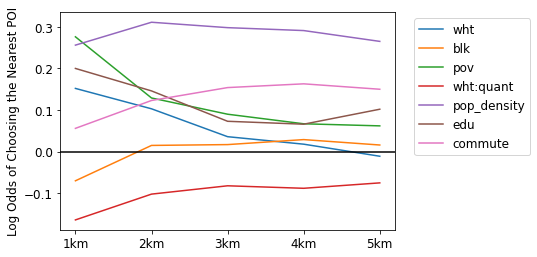

In [68]:
'''
GS - Weekdays
within km radius of choice
'''
x_vals = ['1km','2km','3km','4km','5km']

wht = [0.152, 0.103, 0.036,0.018, -0.011]
blk = [-0.070, 0.015, 0.017,0.029, 0.016]
poverty = [0.276, 0.129, 0.090, 0.067, 0.062]
whtxquant = [-0.164, -0.102, -0.082, -0.088, -0.075]
pop_density = [0.256, 0.311, 0.298, 0.291, 0.265]
edu = [0.200, 0.146, 0.073, 0.066, 0.102]
commute = [0.056, 0.123, 0.154, 0.163, 0.150]

sns.lineplot(x_vals, wht)
sns.lineplot(x_vals, blk)
sns.lineplot(x_vals, poverty)
sns.lineplot(x_vals, whtxquant)
sns.lineplot(x_vals, pop_density)
sns.lineplot(x_vals, edu)
sns.lineplot(x_vals, commute)
plt.ylabel("Log Odds of Choosing the Nearest POI")
plt.axhline(0, color='black')
plt.legend(labels=['wht','blk','pov','wht:quant','pop_density','edu','commute'], bbox_to_anchor=(1.04,1), loc="upper left")
plt.show()

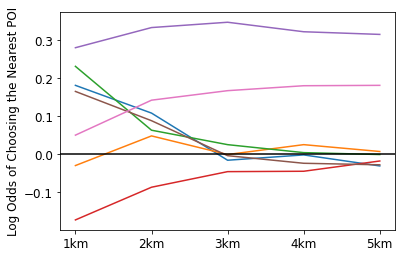

In [69]:
'''
GS - Weekends
within km radius of choice
'''
x_vals = ['1km','2km','3km', '4km','5km']

wht = [0.181, 0.108, -0.016, -0.002, -0.031]
blk = [-0.03, 0.048, -0.001, 0.025, 0.007]
poverty = [0.231, 0.063, 0.025, 0.004, -0.001]
whtxquant = [-0.173, -0.087, -0.046, -0.045, -0.018]
pop_density = [0.280, 0.333, 0.347, 0.322, 0.315]
edu = [0.165, 0.088, -0.004, -0.024, -0.028]
commute = [0.05, 0.142, 0.167, 0.18, 0.181]

sns.lineplot(x_vals, wht)
sns.lineplot(x_vals, blk)
sns.lineplot(x_vals, poverty)
sns.lineplot(x_vals, whtxquant)
sns.lineplot(x_vals, pop_density)
sns.lineplot(x_vals, edu)
sns.lineplot(x_vals, commute)
plt.ylabel("Log Odds of Choosing the Nearest POI")
plt.axhline(0, color='black')
# plt.legend(labels=['wht','blk','pov','wht:quant','pop_density','edu','commute'])
plt.show()

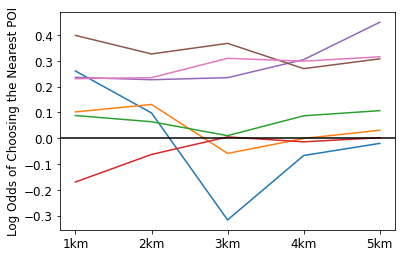

In [70]:
'''
PS - Weekdays
within km radius of choice
'''
x_vals = ['1km','2km','3km', '4km','5km']

wht = [0.261, 0.098, -0.317, -0.067, -0.02]
blk = [0.102, 0.131, -0.059, -0.001, 0.031]
poverty = [0.088, 0.064, 0.010, 0.087, 0.107]
whtxquant = [-0.170, -0.063, 0.005, -0.014, 0.002]
pop_density = [0.236, 0.227, 0.235, 0.305, 0.450]
edu = [0.399, 0.327, 0.368, 0.270, 0.308]
commute = [0.231, 0.235, 0.310, 0.299, 0.316]

sns.lineplot(x_vals, wht)
sns.lineplot(x_vals, blk)
sns.lineplot(x_vals, poverty)
sns.lineplot(x_vals, whtxquant)
sns.lineplot(x_vals, pop_density)
sns.lineplot(x_vals, edu)
sns.lineplot(x_vals, commute)
plt.ylabel("Log Odds of Choosing the Nearest POI")
plt.axhline(0, color='black')
# plt.legend(labels=['wht','blk','pov','wht:quant','pop_density','edu','commute'])
plt.show()

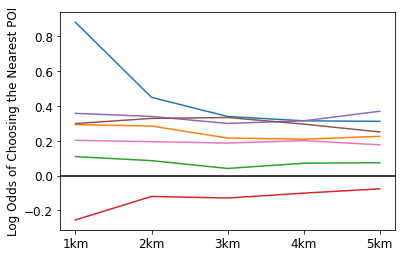

In [72]:
'''
PS - Weekends
within km radius of choice
'''
x_vals = ['1km','2km','3km', '4km','5km']

wht = [0.882, 0.45, 0.34, 0.315, 0.312]
blk = [0.293, 0.285, 0.216, 0.209, 0.226]
poverty = [0.109, 0.086, 0.041, 0.071, 0.074]
whtxquant = [-0.255, -0.12, -0.129, -0.101, -0.076]
pop_density = [0.358,0.340,0.3,0.315,0.370]
edu = [0.299,0.329,0.334,0.296,0.251]
commute = [0.203,0.195,0.187,0.201,0.177]

sns.lineplot(x_vals, wht)
sns.lineplot(x_vals, blk)
sns.lineplot(x_vals, poverty)
sns.lineplot(x_vals, whtxquant)
sns.lineplot(x_vals, pop_density)
sns.lineplot(x_vals, edu)
sns.lineplot(x_vals, commute)
plt.ylabel("Log Odds of Choosing the Nearest POI")
plt.axhline(0, color='black')
# plt.legend(labels=['wht','blk','pov','wht:quant','pop_density','edu','commute'])
plt.show()

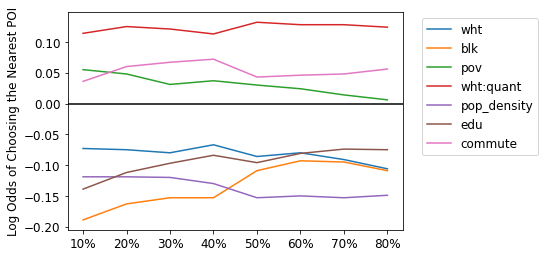

In [74]:
'''
GS - Weekdays 
within _% of distance from closest POI
'''
x_vals = ['10%','20%','30%','40%','50%','60%','70%','80%']

wht = [-0.073, -0.075, -0.080, -0.067, -0.086, -0.080, -0.091, -0.106]
blk = [-0.189, -0.163, -0.153, -0.153, -0.109, -0.093, -0.095, -0.109]
poverty = [0.055, 0.048, 0.031, 0.037, 0.030, 0.024, 0.014, 0.006]
whtxquant = [0.114, 0.125, 0.121, 0.113, 0.132, 0.128, 0.128, 0.124]
pop_density = [-0.119, -0.119, -0.120, -0.130, -0.153, -0.150, -0.153, -0.149]
edu = [-0.139, -0.112, -0.097, -0.084, -0.096, -0.081, -0.074, -0.075]
commute = [0.036, 0.060, 0.067, 0.072, 0.043, 0.046, 0.048, 0.056]

sns.lineplot(x_vals, wht)
sns.lineplot(x_vals, blk)
sns.lineplot(x_vals, poverty)
sns.lineplot(x_vals, whtxquant)
sns.lineplot(x_vals, pop_density)
sns.lineplot(x_vals, edu)
sns.lineplot(x_vals, commute)
plt.axhline(0, color='black')
plt.ylabel("Log Odds of Choosing the Nearest POI")
plt.legend(labels=['wht','blk','pov','wht:quant','pop_density','edu','commute'], bbox_to_anchor=(1.04,1), loc="upper left")
plt.show()

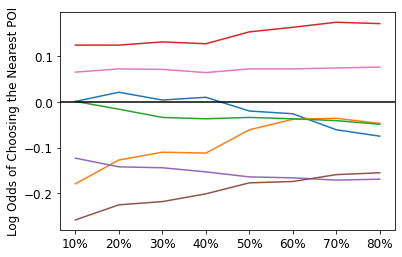

In [75]:
'''
GS - Weekends 
within _% of distance from closest POI
'''
x_vals = ['10%','20%','30%','40%','50%','60%','70%','80%']

wht = [0.001,0.021,0.004,0.01,-0.02,-0.026,-0.061,-0.075]
blk = [-0.179,-0.127,-0.110,-0.112,-0.061,-0.038,-0.036,-0.047]
poverty = [0.001,-0.016,-0.034,-0.037,-0.034,-0.037,-0.041,-0.049]
whtxquant = [0.124,0.124,0.131,0.127,0.153,0.163,0.174,0.171]
pop_density = [-0.123,-0.142,-0.144,-0.153,-0.164,-0.166,-0.171,-0.169]
edu = [-0.258,-0.225,-0.218,-0.201,-0.177,-0.174,-0.159,-0.155]
commute = [0.065,0.072,0.071,0.064,0.072,0.072,0.074,0.076]

sns.lineplot(x_vals, wht)
sns.lineplot(x_vals, blk)
sns.lineplot(x_vals, poverty)
sns.lineplot(x_vals, whtxquant)
sns.lineplot(x_vals, pop_density)
sns.lineplot(x_vals, edu)
sns.lineplot(x_vals, commute)
plt.axhline(0, color='black')
plt.ylabel("Log Odds of Choosing the Nearest POI")
# plt.legend(labels=['wht','blk','pov','wht:quant','pop_density','edu','commute'], loc=1)
plt.show()

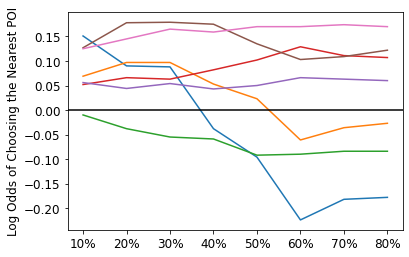

In [76]:
'''
PS - Weekdays 
within _% of distance from closest POI
'''
x_vals = ['10%','20%','30%','40%','50%','60%','70%','80%']

wht = [0.151,0.090,0.088,-0.038,-0.096,-0.224,-0.182,-0.178]
blk = [0.069,0.097,0.097,0.053,0.023,-0.061,-0.036,-0.027]
poverty = [-0.010,-0.038,-0.055,-0.059,-0.092,-0.090,-0.084,-0.084]
whtxquant = [0.052,0.066,0.063,0.082,0.102,0.129,0.111,0.107]
pop_density = [0.056,0.044,0.054,0.043,0.050,0.066,0.063,0.060]
edu = [0.127,0.178,0.179,0.175,0.135,0.103,0.109,0.122]
commute = [0.125,0.145,0.165,0.159,0.170,0.170,0.174,0.170]

sns.lineplot(x_vals, wht)
sns.lineplot(x_vals, blk)
sns.lineplot(x_vals, poverty)
sns.lineplot(x_vals, whtxquant)
sns.lineplot(x_vals, pop_density)
sns.lineplot(x_vals, edu)
sns.lineplot(x_vals, commute)
plt.axhline(0, color='black')
plt.ylabel("Log Odds of Choosing the Nearest POI")
# plt.legend(labels=['wht','blk','pov','wht:quant','pop_density','edu','commute'], loc=1)
plt.show()

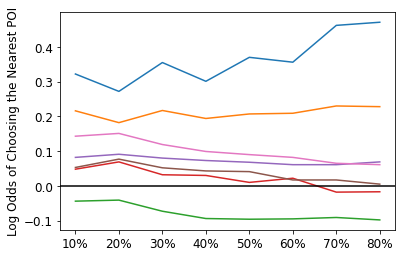

In [77]:
'''
PS - Weekends 
within _% of distance from closest POI
'''
x_vals = ['10%','20%','30%','40%','50%','60%','70%','80%']

wht = [0.322,0.272,0.355,0.301,0.370,0.356,0.462,0.471]
blk = [0.216,0.182,0.217,0.194,0.207,0.209,0.230,0.228]
poverty = [-0.044,-0.041,-0.073,-0.094,-0.096,-0.095,-0.091,-0.098]
whtxquant = [0.048,0.069,0.032,0.030,0.01,0.022,-0.018,-0.017]
pop_density = [0.082,0.091,0.080,0.073,0.068,0.061,0.061,0.069]
edu = [0.053,0.077,0.052,0.043,0.041,0.017,0.017,0.005]
commute = [0.143,0.151,0.119,0.099,0.090,0.082,0.065,0.061]

sns.lineplot(x_vals, wht)
sns.lineplot(x_vals, blk)
sns.lineplot(x_vals, poverty)
sns.lineplot(x_vals, whtxquant)
sns.lineplot(x_vals, pop_density)
sns.lineplot(x_vals, edu)
sns.lineplot(x_vals, commute)
plt.axhline(0, color='black')
plt.ylabel("Log Odds of Choosing the Nearest POI")
# plt.legend(labels=['wht','blk','pov','wht:quant','pop_density','edu','commute'], loc=1)
plt.show()

In [1959]:
ma_geodata['square_miles'] = ma_geodata['ALAND'].astype(int)/(2.59*(10**6))
ma_geodata['ppsm'] = ma_geodata['population']/ma_geodata['square_miles']

# for people not choosing closest POI, is their previous stay in home CBG?

In [ ]:
stays = valid_gssm_stays[valid_gssm_stays['logit']==0]

home_b4_poi = 0
for i, r in tqdm(stays.iterrows()):
    user_stays = full_stays[full_stays['user']==r['user']]
    stays_before_poi = user_stays[user_stays['ini_dat'] < r['ini_dat']].sort_values(by='ini_dat', ascending=False)
    if not stays_before_poi.empty:
        prev_stay = stays_before_poi.reset_index().iloc[0]
        if prev_stay['GEOID']  == prev_stay['GEOID_home']: 
            home_b4_poi += 1
print(home_b4_poi, stays.shape[0])

3220it [47:41,  1.14it/s]

# creating list of closest vs choice stores

In [101]:
q1_gssm_stays = valid_gssm_stays[valid_gssm_stays['quant']==1]
q1_gssm_stays = q1_gssm_stays.drop_duplicates(subset=['user'], keep='first')
q4_gssm_stays = valid_gssm_stays[valid_gssm_stays['quant']==4]
q4_gssm_stays = q4_gssm_stays.drop_duplicates(subset=['user'], keep='first')


In [122]:
'''
Choice POI - top 15
'''
# dict of fsq id to grocery store name
gs_dict = {}
for i,r in grocery_stores.iterrows():
    gs_dict[r['id']] = r['name']
    
choice_poi = {}    
for i,r in valid_gssm_stays.iterrows():
    name = gs_dict[r['fsq_id']]
    if name not in choice_poi:
        choice_poi[name] = 1
    else: choice_poi[name] += 1
        
# put repeat names together: Big Y, Market Basket 
final_list = {"Stop & Shop":0, "Star Market":0, 'Market Basket':0, 
         'Shaw\'s':0, 'Hannaford':0, 'Roche Bros':0, 'Valle Sultana':0,
        'C-Mart':0, 'Hingham Farmers Market':0, 'Aldi':0, 'Tesoro':0,
        "Trucci\'s":0, 'Big Y': 0, "Stillman\'s Farm":0, 'McKinnon\'s Butcher Shop':0,
        "Village Market":0}

values = sum(choice_poi.values())
for store, v in choice_poi.items():
    if store in stop_shop: final_list['Stop & Shop'] += v/values
    elif store in star_market: final_list['Star Market'] += v/values  
    elif store in market_basket: final_list['Market Basket'] += v/values 
    elif store in shaws: final_list['Shaw\'s'] += v/values
    elif store in hannaford: final_list['Hannaford'] += v/values
    elif store in roche_bros: final_list['Roche Bros'] += v/values
    elif store in valle_sultana: final_list['Valle Sultana'] += v/values
    elif store in c_mart: final_list['C-Mart'] += v/values
    elif store in hingham: final_list['Hingham Farmers Market'] += v/values
    elif store in aldi: final_list['Aldi'] += v/values
    elif store in tesoro: final_list['Tesoro'] += v/values
    elif store in trucci: final_list['Trucci\'s'] += v/values
    elif store in big_y: final_list['Big Y'] += v/values
    elif store in stillman: final_list['Stillman\'s Farm'] += v/values
    elif store in mckinnon: final_list['McKinnon\'s Butcher Shop'] += v/values
    elif store in village_market: final_list['Village Market'] += v/values
    else: final_list[store] = v/values

dict(sorted(final_list.items(), key=lambda item: item[1], reverse=True))

{'Market Basket': 0.3237411265176143,
 'Stop & Shop': 0.17156919657666028,
 "Shaw's": 0.08761527234127248,
 'Hannaford': 0.07969133550056394,
 'Whole Foods Market': 0.06692015524447688,
 'Star Market': 0.037509122271611496,
 'Wegmans': 0.02404962515756651,
 'Roche Bros': 0.02112635175479334,
 'Big Y': 0.013306077091488093,
 'Price Rite': 0.006787799376368341,
 'Sudbury Farms': 0.006543156637696544,
 "McKinnon's Butcher Shop": 0.005722152192662377,
 "Trader Joe's": 0.0053779937636834075,
 'Aldi': 0.005336528892722086,
 "America's Food Basket": 0.004515524447687919,
 "Russo's": 0.004096729250978571,
 'Save-A-Lot': 0.003810621641345452,
 'Tropical Foods - Dudley Square': 0.003773303257480263,
 'Tendercrop Farm at the Red Barn': 0.003541099980096862,
 'The Market at Pinehills': 0.0032135274995024215,
 'Wilson Farm': 0.003167916141444968,
 "Vicente's Tropical": 0.003155476680156571,
 'H Mart': 0.0029813242221190207,
 "Shaws' Supermarket Hanson": 0.0029688847608306244,
 "Vincente's Supermark

In [92]:
poi_data = pd.read_csv("/data/foursquare/14460_foursquare_verified.csv", sep = "|")
grocery_stores = poi_data[poi_data['id'].isin(valid_groceries_fsq_list)]

In [112]:
import geopy.distance

gs_weights = {}

# gssm = valid_gssm_stays.drop_duplicates(subset=['user'], keep='first')
# gssm = gssm[(gssm['quant']!=4)]
# print(gssm.shape)

for i, stay in tqdm(q1_gssm_stays.iterrows()):
    valid_stores_withinR = []
    
    for j, store in grocery_stores.iterrows():
        coords_1 = (stay['home_lat_med'], stay['home_lon_med'])
        coords_2 = (store['lat'], store['lon'])
        if geopy.distance.geodesic(coords_1, coords_2).km < max(1.2*stay['distclosest'], 1):
            valid_stores_withinR.append(store['name'])
    
    if valid_stores_withinR:        
        for s in valid_stores_withinR:
            if s not in gs_weights:
                gs_weights[s] = 1/len(valid_stores_withinR)
            else: gs_weights[s] += 1/len(valid_stores_withinR)

3811it [29:16,  2.18it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

10094it [1:17:32,  2.17it/s]


In [113]:
gs_weights

{'Whole Foods Market': 319.8084279025055,
 "Cambridge Farmers' Market": 4.669264069264069,
 'Broadway Marketplace': 4.516702741702741,
 'Market in the Square': 16.848556998556994,
 'Harvard Market': 15.273881673881661,
 '99 Asian Supermarket': 70.21111111111126,
 "McKinnon's Butcher Shop": 103.37658730158729,
 'Super Stop & Shop': 707.4370766058862,
 'Waltham Farmers Market': 29.698484848484792,
 "Durham Farmer's Market": 56.5,
 'Star Market': 178.52044864320405,
 "Stillman's Farm - Belmont Farmers’ Market": 1.3333333333333333,
 "Belmont Farmers' Market": 0.6666666666666666,
 'Shivalic': 20.65431512931511,
 'Market Basket': 1349.6519627431298,
 'Somerville Winter Farmers Market': 13.768326118326106,
 'Taj Mahal Desi Bazaar': 10.220014707514707,
 "America's Food Basket": 161.77909867909847,
 'Bowdoin Geneva Farmers’ Market': 17.382273282273278,
 'A-C Farm Market': 19.771761571761555,
 'Daily Table': 45.161011211011306,
 'Angkor Thom Market': 37.37171717171718,
 'Bangkok Market': 34.2188

In [114]:
# gs_weights
stop_shop = ['Super Stop & Shop',  'Stop & Shop', 'Super Stop & Shop #410', 'stop & Shop', 'Citizens Bank - Abington Stop & Shop', 'Stop amd shop', 'Super Stop And Shop', 'Stop and Shop', 'Super Stop and Shop', 'Stop & Shop Supermarket', 'Stop And Shop North Andover Ma', 'Super Stop & Stop']
star_market = ['Star Market', "Star Market (Shaw's)", 'Star Market (Franklin)', 'Star Market  (Dedham Plaza)']
market_basket = ['Market Basket', 'Market Basket Plymouth', 'The New Market Basket at Westgate Plaza']
shaws = ["Shaw\'s", 'Shaws', "Shaw's-Osco", "Shaw\'s Supermarket", 'Shaws Supermarket Medford', 'Shaws Supermarket']
hannaford = ['Hannaford Supermarket', 'Hannaford', 'Hannaford Supermarket & Pharmacy']
roche_bros = ['Roche Bros Downtown Crossing', 'Roche Bros.', 'Roche Bros', 'Roche Brothers']
valle_sultana = ['El Vale De La Sultana', 'El Valle de la Sultana']
c_mart = ['C Mart 2 Supermarket', 'C-Mart (Herald St)', 'C-Mart']
hingham = ['Hingham Farmers Market Inc', 'Hingham Farmers Market', "Hingham Farmer's Market"]
aldi = ['Aldi', 'ALDI','Aldi Food Market']
tesoro = ['Tesoro Supermarket', 'Tesoro Market']
trucci = ["Trucchi's", "Trucchi's Supermarkets"]
big_y = ['Big Y', 'Big Y World Class Market & Pharmacy', 'Big Y World Class Markets']
stillman = ['Stillman\'s Farm - Belmont Farmers’ Market',
            'Stillman\'s Farm - Union Square Farmers’ Market',
            'Stillman\'s Farm - Cambridgeport Farmers’ Market',
            'Stillman\'s Farm - Quincy Farmers’ Market',
            'Stillman\'s Farm - Charlestown Farmers’ Market',
            'Stillman\'s Farm - Jamaica Plain Farmers’ Market',
            'Stillman\'s Farm - Loring-Greenough- Jamaica Plain Farmers’ Market',
            "Stillman\'s Farm - Acton-Boxborough Farmers’ Market"]
mckinnon = ['McKinnon\'s Butcher Shop',
            'McKinnon\'s Market & Super Butcher Shop',
            'McKinnon\'s Meat Market']
village_market = ['The Village Market', 'Village Market']

q1_gs = {"Stop & Shop":0, "Star Market":0, 'Market Basket':0, 
         'Shaw\'s':0, 'Hannaford':0, 'Roche Bros':0, 'Valle Sultana':0,
        'C-Mart':0, 'Hingham Farmers Market':0, 'Aldi':0, 'Tesoro':0,
        "Trucci\'s":0, 'Big Y': 0, "Stillman\'s Farm":0, 'McKinnon\'s Butcher Shop':0,
        "Village Market":0}

for store in gs_weights:
    if store in stop_shop: q1_gs['Stop & Shop'] += gs_weights[store]
    elif store in star_market: q1_gs['Star Market'] += gs_weights[store]   
    elif store in market_basket: q1_gs['Market Basket'] += gs_weights[store] 
    elif store in shaws: q1_gs['Shaw\'s'] += gs_weights[store]
    elif store in hannaford: q1_gs['Hannaford'] += gs_weights[store]
    elif store in roche_bros: q1_gs['Roche Bros'] += gs_weights[store]
    elif store in valle_sultana: q1_gs['Valle Sultana'] += gs_weights[store]
    elif store in c_mart: q1_gs['C-Mart'] += gs_weights[store]
    elif store in hingham: q1_gs['Hingham Farmers Market'] += gs_weights[store]
    elif store in aldi: q1_gs['Aldi'] += gs_weights[store]  
    elif store in tesoro: q1_gs['Tesoro'] += gs_weights[store] 
    elif store in trucci: q1_gs['Trucci\'s'] += gs_weights[store]
    elif store in big_y: q1_gs['Big Y'] += gs_weights[store]
    elif store in stillman: q1_gs['Stillman\'s Farm'] += gs_weights[store]
    elif store in mckinnon: q1_gs['McKinnon\'s Butcher Shop'] += gs_weights[store]
    elif store in village_market: q1_gs['Village Market'] += gs_weights[store]
    else: q1_gs[store] = gs_weights[store]

dict(sorted(q1_gs.items(), key=lambda item: item[1], reverse=True))
        

{'Market Basket': 1393.5614865526536,
 'Stop & Shop': 1369.6897784791763,
 "Shaw's": 783.4426201249756,
 'Hannaford': 621.6582887700528,
 'Whole Foods Market': 319.8084279025055,
 'Star Market': 195.9072979050533,
 "America's Food Basket": 161.77909867909847,
 "McKinnon's Butcher Shop": 135.44325396825397,
 "Vicente's Tropical": 125.04642857142855,
 'Save-A-Lot': 107.84594572094576,
 'New Angkor Thom Market': 106.41666666666671,
 'Roche Bros': 101.51287323787326,
 'Seabra': 99.64285714285714,
 'Tesoro': 99.07301587301588,
 "Haverhill Farmer's Market": 92.65641025641041,
 'Aldi': 87.46810493428141,
 'Janetos Superette': 76.30000000000001,
 'Central Square Farmers Market': 71.8166666666667,
 'Preparations Inc.': 71.22170329670334,
 'bfresh': 70.56187146187166,
 'Batambang Market International Foods': 70.36785714285718,
 '99 Asian Supermarket': 70.21111111111126,
 'Sudbury Farms': 66.9318181818183,
 'Price Rite': 64.93333333333348,
 'Hong Kong Supermarket': 62.28475968476005,
 'Winthrop M

In [108]:
# COMBINE Q1,2,3 AND Q4 GS WEIGHTS
# gs_weights
for gs, w in q4_gs.items():
    if gs not in q1_gs:
        q1_gs[gs] = w
    else: q1_gs[gs] += w

In [111]:
import copy
all_q_gs = copy.deepcopy(q1_gs)

In [119]:
filtered_q1_gs = {k:v for (k,v) in q1_gs.items() if v > 80}

q1_as_prop = {}
for gs, w in filtered_q1_gs.items():
    if gs in all_q_gs:
        q1_as_prop[gs] = w/all_q_gs[gs]
    else: q1_as_prop[gs] = w
        
dict(sorted(q1_as_prop.items(), key=lambda item: item[1], reverse=True))

{'Seabra': 0.9358717285487465,
 "Vicente's Tropical": 0.7606575961479588,
 'New Angkor Thom Market': 0.7181765594369637,
 'Tesoro': 0.7177552897884084,
 'Save-A-Lot': 0.6913275803706795,
 "America's Food Basket": 0.6744985423858029,
 "Haverhill Farmer's Market": 0.5593052163299289,
 "McKinnon's Butcher Shop": 0.3194458589164508,
 'Market Basket': 0.30317315723705685,
 'Hannaford': 0.26908213570528633,
 'Stop & Shop': 0.26718687564424515,
 "Shaw's": 0.23954836132777627,
 'Star Market': 0.2141004923663338,
 'Aldi': 0.20291240436956323,
 'Whole Foods Market': 0.15800419426362486,
 'Roche Bros': 0.12158781441570221}

In [120]:
filtered_q4_gs = {k:v for (k,v) in q4_gs.items() if v > 80}

q4_as_prop = {}
for gs, w in filtered_q4_gs.items():
    if gs in all_q_gs:
        q4_as_prop[gs] = w/all_q_gs[gs]
    else: q4_as_prop[gs] = w
        
dict(sorted(q4_as_prop.items(), key=lambda item: item[1], reverse=True))

{'Water Fresh Farms': 0.9275522718434986,
 'Wilson Farm': 0.9011624292907318,
 'Strawberry Hill Farmstand': 0.8766753428382736,
 'Brothers Marketplace': 0.7203158338203118,
 "Crosby's Marketplace": 0.64559890430606,
 'Indian Basket': 0.6202978104962403,
 "Stillman's Farm": 0.5864251807439489,
 'Wegmans': 0.5560064291805451,
 'Sudbury Farms': 0.5320259815216284,
 'Roche Bros': 0.4858425646696448,
 'Whole Foods Market': 0.3929697268822009,
 'Star Market': 0.27798201057220007,
 'Big Y': 0.26827574721076153,
 "Shaw's": 0.23772758455923923,
 'Stop & Shop': 0.18829744607655122,
 'Market Basket': 0.15559598226752414,
 'Hannaford': 0.10192269485050298}

In [115]:
dict(sorted(all_q_gs.items(), key=lambda item: factor*item[1], reverse=True))

{'Stop & Shop': 5126.336296184306,
 'Market Basket': 4596.585988194864,
 "Shaw's": 3270.4987660215456,
 'Hannaford': 2310.2919379639807,
 'Whole Foods Market': 2024.0502436847692,
 'Star Market': 915.0249760745469,
 'Roche Bros': 834.8934778184778,
 'Aldi': 431.0633704530761,
 "McKinnon's Butcher Shop": 423.99439588189614,
 'Big Y': 301.06169247419245,
 'Sudbury Farms': 292.7774753024752,
 "America's Food Basket": 239.85092407592379,
 'Wegmans': 228.05919913419928,
 "Crosby's Marketplace": 213.46542624042615,
 "Stillman's Farm": 208.97704839163816,
 "Trader Joe's": 197.55998527616183,
 'Price Rite': 192.07884615384594,
 'Village Market': 188.54365079365084,
 'Price Chopper': 181.71785714285727,
 "Haverhill Farmer's Market": 165.66341158841126,
 "Vicente's Tropical": 164.3925324675325,
 'Save-A-Lot': 155.99832667332666,
 'Partridge Farm Stand': 151.45247554732833,
 'New Angkor Thom Market': 148.17619047619056,
 'bfresh': 145.13002553002534,
 'E-Z Indian Grocery': 142.96666666666658,
 'F

In [127]:
factor=1.0/sum(all_q_gs.values())
for k in all_q_gs:
    all_q_gs[k] = all_q_gs[k]*factor

In [128]:
dict(sorted(all_q_gs.items(), key=lambda item: item[1], reverse=True))

{'Stop & Shop': 0.14326578436600237,
 'Market Basket': 0.1284608459056189,
 "Shaw's": 0.09140066977870269,
 'Hannaford': 0.06456575758660714,
 'Whole Foods Market': 0.05656615738876434,
 'Star Market': 0.025572214411562943,
 'Roche Bros': 0.023332778431012138,
 'Aldi': 0.012046933386984386,
 "McKinnon's Butcher Shop": 0.011849376666533323,
 'Big Y': 0.008413774872119834,
 'Sudbury Farms': 0.008182255751564324,
 "America's Food Basket": 0.006703116764739907,
 'Wegmans': 0.006373573280817139,
 "Crosby's Marketplace": 0.005965720927852713,
 "Stillman's Farm": 0.005840284176167844,
 "Trader Joe's": 0.005521211370973156,
 'Price Rite': 0.005368029907602862,
 'Village Market': 0.005269231758807515,
 'Price Chopper': 0.005078471218569586,
 "Haverhill Farmer's Market": 0.004629797428550975,
 "Vicente's Tropical": 0.004594280153919071,
 'Save-A-Lot': 0.004359687179959934,
 'Partridge Farm Stand': 0.0042326442218805,
 'New Angkor Thom Market': 0.004141081842160592,
 'bfresh': 0.00405595063244159

In [103]:
q4_gs = {"Stop & Shop":0, "Star Market":0, 'Market Basket':0, 
         'Shaw\'s':0, 'Hannaford':0, 'Roche Bros':0, 'Valle Sultana':0,
        'C-Mart':0, 'Hingham Farmers Market':0, 'Aldi':0, 'Tesoro':0,
        "Trucci\'s":0, 'Big Y': 0, "Stillman\'s Farm":0, 'McKinnon\'s Butcher Shop':0,
        "Village Market":0}

for store in gs_weights_q4:
    if store in stop_shop: q4_gs['Stop & Shop'] += gs_weights_q4[store]
    elif store in star_market: q4_gs['Star Market'] += gs_weights_q4[store]   
    elif store in market_basket: q4_gs['Market Basket'] += gs_weights_q4[store] 
    elif store in shaws: q4_gs['Shaw\'s'] += gs_weights_q4[store]
    elif store in hannaford: q4_gs['Hannaford'] += gs_weights_q4[store]
    elif store in roche_bros: q4_gs['Roche Bros'] += gs_weights_q4[store]
    elif store in valle_sultana: q4_gs['Valle Sultana'] += gs_weights_q4[store]
    elif store in c_mart: q4_gs['C-Mart'] += gs_weights_q4[store]
    elif store in hingham: q4_gs['Hingham Farmers Market'] += gs_weights_q4[store]
    elif store in aldi: q4_gs['Aldi'] += gs_weights_q4[store]  
    elif store in tesoro: q4_gs['Tesoro'] += gs_weights_q4[store] 
    elif store in trucci: q4_gs['Trucci\'s'] += gs_weights_q4[store]
    elif store in big_y: q4_gs['Big Y'] += gs_weights_q4[store]
    elif store in stillman: q4_gs['Stillman\'s Farm'] += gs_weights_q4[store]
    elif store in mckinnon: q4_gs['McKinnon\'s Butcher Shop'] += gs_weights_q4[store]
    elif store in village_market: q4_gs['Village Market'] += gs_weights_q4[store]
    else: q4_gs[store] = gs_weights_q4[store]

dict(sorted(q4_gs.items(), key=lambda item: item[1], reverse=True))

{'Stop & Shop': 965.2760323010316,
 'Whole Foods Market': 795.3904714566559,
 "Shaw's": 777.4877719502746,
 'Market Basket': 715.2103119103178,
 'Roche Bros': 405.62678848928846,
 'Star Market': 254.3604825729818,
 'Hannaford': 235.47118020867995,
 'Sudbury Farms': 155.7652236652237,
 "Crosby's Marketplace": 137.8130452880452,
 'Wegmans': 126.802380952381,
 "Stillman's Farm": 122.54940337440337,
 'Strawberry Hill Farmstand': 107.45952380952382,
 'Water Fresh Farms': 98.4412698412699,
 'Indian Basket': 86.71673881673883,
 'Brothers Marketplace': 84.13174603174606,
 'Big Y': 80.76755050505048,
 'Wilson Farm': 80.53888888888895,
 'Pamplemousse Reading': 73.5685425685426,
 'Baza Foods': 63.68293650793659,
 'Village Market': 61.1376984126984,
 "Donelan's Supermarket": 57.759523809523856,
 'Price Chopper': 55.99285714285728,
 "Acton Boxborough Farmer's Market": 55.08333333333336,
 "Donelan's": 54.62735597735598,
 "Lexington Farmers' Market": 48.52222222222225,
 'Newton Winter Farmers Market'

In [147]:
# dict of grocery store id to names
gs_dict = {}
for i, store in grocery_stores.iterrows():
    gs_dict[store['id']] = store['name']
gs_dict

{'4c0d2cb52466a593452c7721': "Shaw's Supermarket",
 '4b114f5bf964a520137a23e3': "Shaw's",
 '4b5e3cc7f964a5207d8529e3': "McKinnon's Market & Super Butcher Shop",
 '4bc1e37fb492d13aee8ea660': 'Super Stop & Shop',
 '4b8a9dc8f964a5206c7532e3': "Shaw's",
 '54303988498e591cd8b5f966': 'Aldi',
 '4b6d88f5f964a520e37a2ce3': 'Market Basket',
 '4f7a0708e4b0ba0abf7bfa5e': 'The New Market Basket at Westgate Plaza',
 '4c9f21347ada199c55c59dbc': 'Hannaford Supermarket',
 '4cc47f5001fb236a8047acba': 'Market Basket',
 '53d95d30498e97eab6a0b087': 'Star Market',
 '4acb6daef964a520b5c320e3': "Jamaica Plain Farmers' Market",
 '51dc3e21498e5d78b817e2a8': 'Whole Foods Market',
 '4f025ba0490182a1aa002735': 'Shivalic',
 '4c71a27bd944224bc9be0a29': 'Amigos Grocery Store',
 '5984d797f5e9d71716332ae1': "Trader Joe's",
 '4a985929f964a520a22b20e3': 'Stop & Shop',
 '4e137d14b61c18a826f971f0': "Farmer Dave's CSA pickup",
 '4baf839df964a52028063ce3': "Shaw's",
 '4d98a8cea2c65481dd67f653': 'Shiva Bazzar',
 '4bb0f607f964

In [85]:
# relative weight 

McKinnon's Butcher Shop
McKinnon's Market & Super Butcher Shop
McKinnon's Meat Market


In [102]:
gs_weights_q4 = {}

for i, stay in tqdm(q4_gssm_stays.iterrows()):
    valid_stores_withinR = []
    
    for j, store in grocery_stores.iterrows():
        coords_1 = (stay['home_lat_med'], stay['home_lon_med'])
        coords_2 = (store['lat'], store['lon'])
        if geopy.distance.geodesic(coords_1, coords_2).km < max(1.2*stay['distclosest'], 1):
            valid_stores_withinR.append(store['name'])
    
    if valid_stores_withinR:        
        for s in valid_stores_withinR:
            if s not in gs_weights_q4:
                gs_weights_q4[s] = 1/len(valid_stores_withinR)
            else:
                gs_weights_q4[s] += 1/len(valid_stores_withinR)

7903it [1:00:25,  2.18it/s]


In [51]:
gs_weights_q4

{'Star Market': 236.41569541569464,
 'Siena Farms': 9.37121212121212,
 "Deluca's Market": 11.329545454545453,
 "Trader Joe's": 23.493559218559195,
 'South End Open Market @ Ink Block': 19.85422616599085,
 'Whole Foods Market': 795.3904714566559,
 'C-Mart (Herald St)': 6.779247549835781,
 'New York Marts': 6.1863293569175895,
 'Shaws Supermarket Aisle #12': 24.09563492063491,
 'Market Basket': 711.4992007992067,
 'Demulas Market Basket Burlington': 6.583333333333333,
 'Super Stop and Shop': 22.490476190476187,
 "Calareso's Fruit Stand": 29.492857142857137,
 'Nonantum Farmers Market': 11.790476190476186,
 "Russo's": 7.6452380952380965,
 'Super Stop & Shop': 284.96868686868675,
 'Shaws': 5.027380952380953,
 "Shaw's": 762.4112096237122,
 'Stop & Shop': 565.5077672327666,
 'Newton Winter Farmers Market': 47.49404761904764,
 'Aldi': 18.15952380952379,
 'Jay Ambe Indian Grocery': 4.707575757575758,
 'Indian Basket': 86.71673881673883,
 "Crosby's Marketplace": 137.8130452880452,
 "Donelan's Su